# 6.2 AnoGANの作成

- 本ファイルでは、AnoGANのネットワークを実装とAnoGANの学習をします。


# 6.2 学習目標

1.	AnoGANでテスト画像に最も似た画像を生成するノイズzを求める方法を理解する
2.	AnoGANを実装し、手書き数字画像で異常検知が生成できる


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


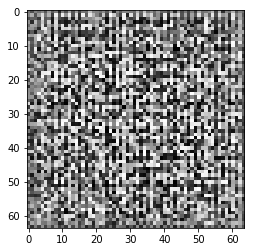

In [4]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last(out)

        return out, feature


In [6]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)


tensor([[[[0.4973]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


# DataLoaderの作成

In [7]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [8]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [9]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [10]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 学習させる

In [11]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [12]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    # Two Time-Scale UpdateでGはDよりも学習率を小さくする
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イタレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイタレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    
    print("総イタレーション回数:", iteration)

    return G, D


In [13]:
# 学習・検証を実行する
# 8分ほどかかる
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1017 ||Epoch_G_Loss:0.0948
timer:  2.4748 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0269 ||Epoch_G_Loss:0.3311
timer:  1.4715 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.3251 ||Epoch_G_Loss:0.4040
timer:  1.4800 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0130 ||Epoch_G_Loss:0.3051
timer:  1.4782 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1287 ||Epoch_G_Loss:0.3168
timer:  1.4828 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0049 ||Epoch_G_Loss:0.4072
timer:  1.4839 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0029 ||Epoch_G_Loss:0.4684
timer:  1.4952 sec.
-------------
Epoch 7/300
-------------


-------------
epoch 60 || Epoch_D_Loss:0.1028 ||Epoch_G_Loss:0.1526
timer:  1.4911 sec.
-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.0938 ||Epoch_G_Loss:0.1771
timer:  1.4996 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.0995 ||Epoch_G_Loss:0.1625
timer:  1.4941 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.0931 ||Epoch_G_Loss:0.1764
timer:  1.4979 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.1149 ||Epoch_G_Loss:0.1654
timer:  1.5010 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.0908 ||Epoch_G_Loss:0.1782
timer:  1.5045 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.1619
timer:  1.5026 sec.
-------------
Epoch 67/300
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.2875
timer:  1.5035 sec.
-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.3087
timer:  1.4996 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.2693
timer:  1.5030 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.3088
timer:  1.5022 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.2725
timer:  1.5014 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.2998
timer:  1.4997 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.2731
timer:  1.5016 sec.
-------------
Epoch 127/300
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0254 ||Epoch_G_Loss:0.4919
timer:  1.4991 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0407 ||Epoch_G_Loss:0.4146
timer:  1.5002 sec.
-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0298 ||Epoch_G_Loss:0.4710
timer:  1.4968 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0243 ||Epoch_G_Loss:0.5469
timer:  1.5024 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.3286
timer:  1.5014 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0158 ||Epoch_G_Loss:0.5386
timer:  1.5029 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0747 ||Epoch_G_Loss:0.3115
timer:  1.5057 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || 

-------------
epoch 238 || Epoch_D_Loss:0.0440 ||Epoch_G_Loss:0.6903
timer:  1.4986 sec.
-------------
Epoch 239/300
-------------
（train）
-------------
epoch 239 || Epoch_D_Loss:0.0207 ||Epoch_G_Loss:0.4699
timer:  1.5040 sec.
-------------
Epoch 240/300
-------------
（train）
-------------
epoch 240 || Epoch_D_Loss:0.0146 ||Epoch_G_Loss:0.6552
timer:  1.5055 sec.
-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:0.0312 ||Epoch_G_Loss:0.5127
timer:  1.5019 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:0.0058 ||Epoch_G_Loss:0.6709
timer:  1.4939 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.5724
timer:  1.4964 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:0.0140 ||Epoch_G_Loss:0.6173
timer:  1.4968 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || 

-------------
epoch 297 || Epoch_D_Loss:0.0035 ||Epoch_G_Loss:0.8149
timer:  1.5011 sec.
-------------
Epoch 298/300
-------------
（train）
-------------
epoch 298 || Epoch_D_Loss:0.0467 ||Epoch_G_Loss:0.6566
timer:  1.5005 sec.
-------------
Epoch 299/300
-------------
（train）
-------------
epoch 299 || Epoch_D_Loss:0.0080 ||Epoch_G_Loss:0.6689
timer:  1.4984 sec.
総イタレーション回数: 2101


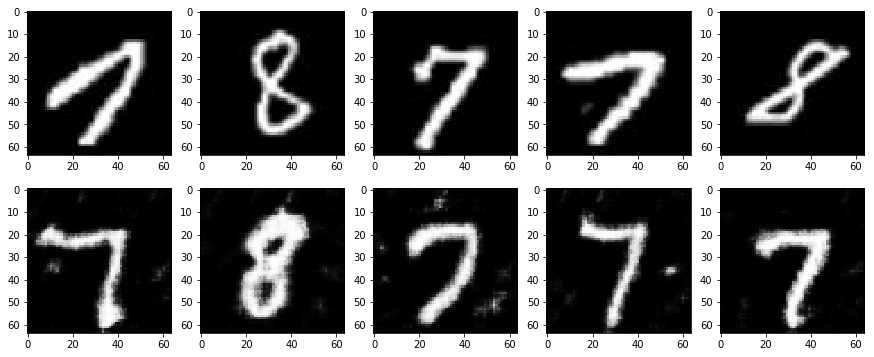

In [30]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

# AnoGANの本体

In [31]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す
    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    # テスト画像xと生成画像fake_imgの特徴量マップの差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


# 教師データでAnoGANの確認

In [32]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)


In [33]:
# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-4)


In [34]:
fake_imges = G_update(z.to(device))
loss, loss_each, residual_loss_each = Anomaly_score(x,fake_imges, D_update,Lambda=0.1)
print(loss.cpu().detach().numpy())
print(loss_each.cpu().detach().numpy())
print(residual_loss_each.cpu().detach().numpy())

5041.1816
[1071.2947 1079.5762  639.9276 1136.435  1113.9482]
[1127.4567  1121.1825   653.36646 1201.2748  1166.7505 ]


In [35]:
for epoch in range(10000+1):
    fake_img = G_update(z)
    loss, _,_ = Anomaly_score(x,fake_img, D_update,Lambda=0.1)
    
    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()
    
    if epoch%1000==0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))


epoch 0 || loss_total:5041 
epoch 1000 || loss_total:4498 
epoch 2000 || loss_total:4079 
epoch 3000 || loss_total:3778 
epoch 4000 || loss_total:3507 
epoch 5000 || loss_total:3304 
epoch 6000 || loss_total:3147 
epoch 7000 || loss_total:2992 
epoch 8000 || loss_total:2837 
epoch 9000 || loss_total:2673 
epoch 10000 || loss_total:2516 


[693. 601. 195. 404. 624.]
[718. 610. 193. 408. 632.]


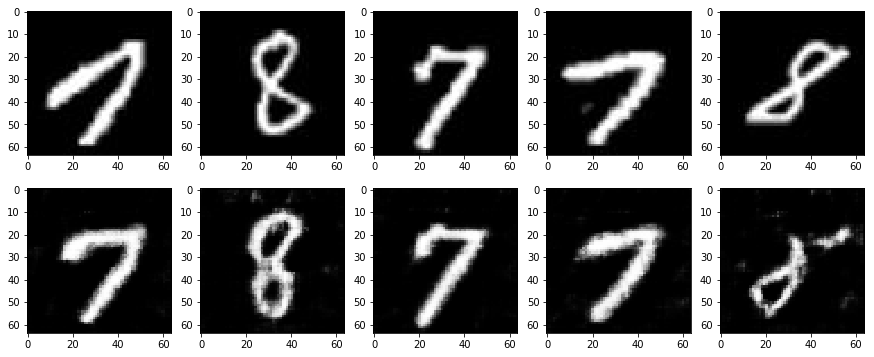

In [36]:
# 出力
fake_img = G_update(z)
loss, loss_each, residual_loss_each  = Anomaly_score(x,fake_img, D_update,Lambda=0.1)

loss_each = loss_each.cpu().detach().numpy() 
print(np.round(loss_each, 0))

residual_loss_each = residual_loss_each.cpu().detach().numpy() 
print(np.round(residual_loss_each, 0))



fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    #plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')

# テスト画像で異常検知する

In [38]:
# テスト用のDataLoaderの作成


def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)


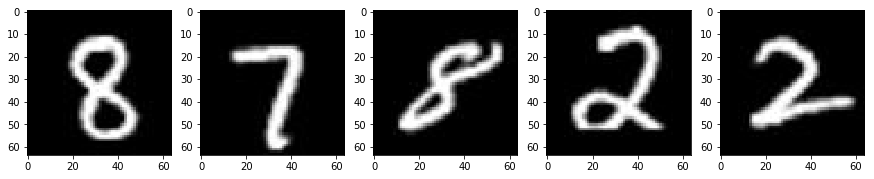

In [45]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [49]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)

# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-4)


# zを求める
for epoch in range(40000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))


epoch 0 || loss_total:5762 
epoch 1000 || loss_total:5503 
epoch 2000 || loss_total:5310 
epoch 3000 || loss_total:5139 
epoch 4000 || loss_total:4963 
epoch 5000 || loss_total:4839 
epoch 6000 || loss_total:4753 
epoch 7000 || loss_total:4661 
epoch 8000 || loss_total:4575 
epoch 9000 || loss_total:4482 
epoch 10000 || loss_total:4400 
epoch 11000 || loss_total:4311 
epoch 12000 || loss_total:4184 
epoch 13000 || loss_total:3815 
epoch 14000 || loss_total:3639 
epoch 15000 || loss_total:3501 
epoch 16000 || loss_total:3339 
epoch 17000 || loss_total:3236 
epoch 18000 || loss_total:3133 
epoch 19000 || loss_total:3033 
epoch 20000 || loss_total:2936 
epoch 21000 || loss_total:2843 
epoch 22000 || loss_total:2780 
epoch 23000 || loss_total:2733 
epoch 24000 || loss_total:2694 
epoch 25000 || loss_total:2663 
epoch 26000 || loss_total:2613 
epoch 27000 || loss_total:2550 
epoch 28000 || loss_total:2484 
epoch 29000 || loss_total:2431 
epoch 30000 || loss_total:2381 
epoch 31000 || loss_t

[368. 144. 416. 722. 567.]
[369. 144. 420. 729. 561.]


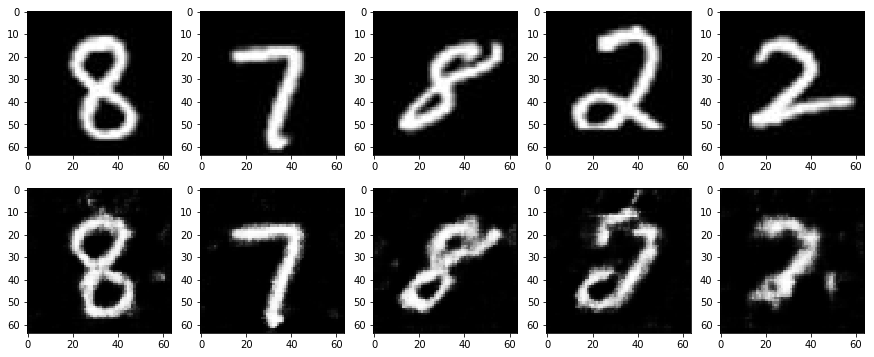

In [50]:
# 画像を生成
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print(np.round(loss_each, 0))

# 損失の計算。画像レベルのresidual loss
residual_loss_each = residual_loss_each.cpu().detach().numpy()
print(np.round(residual_loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    #plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')


以上